<h1><center>TESLA Tutorial</center></h1>


<center>Author: Jian Hu*,  Kyle Coleman, Edward B. Lee, Humam Kadara, Linghua Wang*, Mingyao Li*

### Outline
1. Installation
2. Import modules
3. Read in data
4. Gene expression enhancement
5. Region annotation

### 1. Installation
To install TESLA package you must make sure that your python version is over 3.5.=. If you don’t know the version of python you can check it by:

In [7]:
import platform
platform.python_version()

'3.8.8'

Note: Because SpaGCN pends on pytorch, you should make sure torch is correctly installed.
<br>
Now you can install the current release of SpaGCN by the following three ways:
#### 1.1 PyPI: Directly install the package from PyPI. (Not available now)

In [ ]:
pip3 install TESLA
#Note: you need to make sure that the pip is for python3，or we should install SpaGCN by
python3 -m pip install TESLA
pip3 install TESLA
#If you do not have permission (when you get a permission denied error), you should install SpaGCN by
pip3 install --user TESLA

#### 1.2 Github
Download the package from Github and install it locally:

In [2]:
git clone https://github.com/jianhuupenn/SpaGCN
cd ./TESLA/TESLA_package/
python3 setup.py install --user

#### 1.3 Anaconda ()
If you do not have Python3.5 or Python3.6 installed, consider installing Anaconda (see Installing Anaconda). After installing Anaconda, you can create a new environment, for example, SpaGCN (you can change to any name you like).

In [3]:
#create an environment called TESLA
conda create -n TESLA python=3.7.9
#activate your environment 
conda activate TESLA
git clone https://github.com/jianhuupenn/TESLA
cd TESLA/TESLA_package/
python3 setup.py build
python3 setup.py install
conda deactivate

### 2. Import python modules

In [1]:
import os,csv,re, time
import random
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from scipy import stats
from scipy.sparse import issparse
import scanpy as sc
import matplotlib.colors as clr
import matplotlib.pyplot as plt
import cv2
import TESLA as tesla

In [2]:
tesla.__version__

'1.0.0'

### 3. Read in data
The current version of SpaGCN requres three input data: 
<br>
1. The gene expression matrix(n by k): expression_matrix.h5;
<br>
2. Spatial coordinateds of samplespositions.txt;
<br>
3. Histology image(optional): histology.tif, can be tif or png or jepg.
<br>
The gene expreesion data can be stored as an AnnData object. AnnData stores a data matrix .X together with annotations of observations .obs, variables .var and unstructured annotations .uns. 

In [3]:
"""
#Read original 10x_h5 data and save it to h5ad
from scanpy import read_10x_h5
adata = read_10x_h5("../tutorial/data/151673/expression_matrix.h5")
spatial=pd.read_csv("../tutorial/data/151673/positions.txt",sep=",",header=None,na_filter=False,index_col=0) 
adata.obs["x1"]=spatial[1]
adata.obs["x2"]=spatial[2]
adata.obs["x3"]=spatial[3]
adata.obs["x4"]=spatial[4]
adata.obs["x5"]=spatial[5]
#Select captured samples
adata=adata[adata.obs["x1"]==1]
adata.var_names=[i.upper() for i in list(adata.var_names)]
adata.var["genename"]=adata.var.index.astype("str")
adata.write_h5ad("../tutorial/data/151673/sample_data.h5ad")
"""
#Read in gene expression and spatial location
counts=sc.read("./data/sample_data.h5ad")
#Read in hitology image
img=cv2.imread("./data/sample_H&E.jpg")

### 4. Gene expression enhancement

In [4]:
resize_factor=1000/np.min(img.shape[0:2])
resize_width=int(img.shape[1]*resize_factor)
resize_height=int(img.shape[0]*resize_factor)
counts.var.index=[i.upper() for i in counts.var.index]
counts.var_names_make_unique()
counts.raw=counts
sc.pp.log1p(counts) # impute on log scale
if issparse(counts.X):counts.X=counts.X.A

In [5]:
cnt=tesla.cv2_detect_contour(img, apertureSize=5,L2gradient = True)
binary=np.zeros((img.shape[0:2]), dtype=np.uint8)
cv2.drawContours(binary, [cnt], -1, (1), thickness=-1)
#Enlarged filter
cnt_enlarged = tesla.scale_contour(cnt, 1.05)
binary_enlarged = np.zeros(img.shape[0:2])
cv2.drawContours(binary_enlarged, [cnt_enlarged], -1, (1), thickness=-1)
img_new = img.copy()
cv2.drawContours(img_new, [cnt], -1, (255), thickness=50)
img_new=cv2.resize(img_new, ((resize_width, resize_height)))
cv2.imwrite('./cnt.jpg', img_new)


True

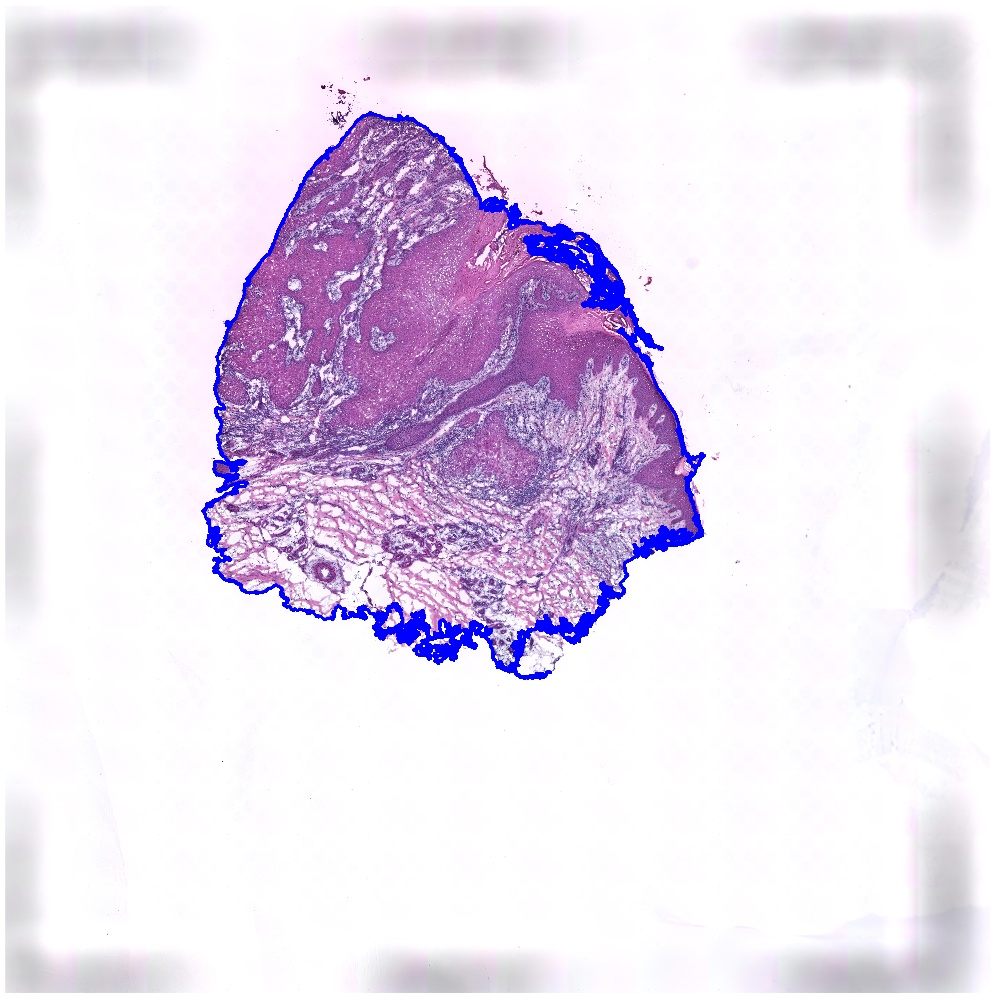

In [6]:
from IPython.display import Image
Image(filename='./cnt.jpg')

In [7]:
res=50
sudo_adata=tesla.imputation(img=img, raw=counts, cnt=cnt, genes=counts.var.index.tolist(), shape="None", res=res, s=1, k=2, num_nbs=10)

Trying to set attribute `.obs` of view, copying.


Total number of sudo points:  19988
Calculating spot 0
Calculating spot 1000
Calculating spot 2000
Calculating spot 3000
Calculating spot 4000
Calculating spot 5000
Calculating spot 6000
Calculating spot 7000
Calculating spot 8000
Calculating spot 9000
Calculating spot 10000
Calculating spot 11000
Calculating spot 12000
Calculating spot 13000
Calculating spot 14000
Calculating spot 15000
Calculating spot 16000
Calculating spot 17000
Calculating spot 18000
Calculating spot 19000
--- 76.36286902427673 seconds ---
Imputing spot 0
Imputing spot 1000
Imputing spot 2000
Imputing spot 3000
Imputing spot 4000
Imputing spot 5000
Imputing spot 6000
Imputing spot 7000
Imputing spot 8000
Imputing spot 9000
Imputing spot 10000
Imputing spot 11000
Imputing spot 12000
Imputing spot 13000
Imputing spot 14000
Imputing spot 15000
Imputing spot 16000
Imputing spot 17000
Imputing spot 18000
Imputing spot 19000


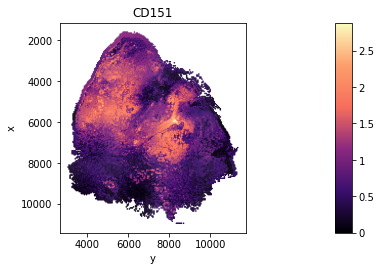

In [10]:
#Plot one gene
cnt_color = clr.LinearSegmentedColormap.from_list('magma', ["#000003",  "#3b0f6f",  "#8c2980",   "#f66e5b", "#fd9f6c", "#fbfcbf"], N=256)
g="CD151"
sudo_adata.obs[g]=sudo_adata.X[:,sudo_adata.var.index==g]

fig=sc.pl.scatter(sudo_adata,alpha=1,x="y",y="x",color=g,color_map=cnt_color,show=False,size=10)
fig.set_aspect('equal', 'box')
fig.invert_yaxis()
fig.figure.show()


### Note, it the numer of spots is too large and take too long, you can increase the res to 100

### 5. Region annotation

#### 5.1 Expression data preprocessing

In [11]:
#Select your gene list
#For example, if we want to annotate B cell, use B cell's markers
genes=['CD79B', 'CD19', 'CD79A', 'MS4A1', 'CD22''CD79B', 'CD19', 'CD79A', 'MS4A1', 'CD22']
pred_refined, target_clusters, c_m=tesla.annotation(img=img, sudo_adata=sudo_adata, genes=genes, resize_factor=resize_factor, binary=binary)
ret_img=tesla.visualize_annotation(pred_refined=pred_refined, target_clusters=target_clusters, c_m=c_m, img=img, binary=binary, resize_factor=resize_factor)
cv2.imwrite('./test.jpg', ret_img)


Computing image band...
Computing gene band...
Running TESLA...
0 / 30 |  label num : 100 |  main clusters : 59  | feature loss : 6.2735514640808105  | spatial loss : 2.4337100982666016
--- 75.00197696685791 seconds ---
1 / 30 |  label num : 77 |  main clusters : 25  | feature loss : 4.363692760467529  | spatial loss : 0.41938120126724243
--- 160.49272108078003 seconds ---
mainLabels 25 reached minLabels 30 .
Finding target clusters...
c_m:
[(9, 0.34743872851167107), (8, 0.20280038405625136), (5, 0.12963002208279314), (16, 0.12599933351888631), (10, 0.0888698821079567), (11, 0.07383142255337906), (4, 0.054116277277026226), (13, 0.04934986010526036), (1, 0.026423890148522554), (2, 0.01876393234799273), (3, 0.015868938579597622), (15, 0.007155518192830438), (12, 0.006567734255725406), (6, 0.0058036171046658), (14, 3.078230326685978e-05), (7, 2.6083808842158785e-05), (0, 6.5920644552905035e-09)]
Target clusters:
[9, 8]


True

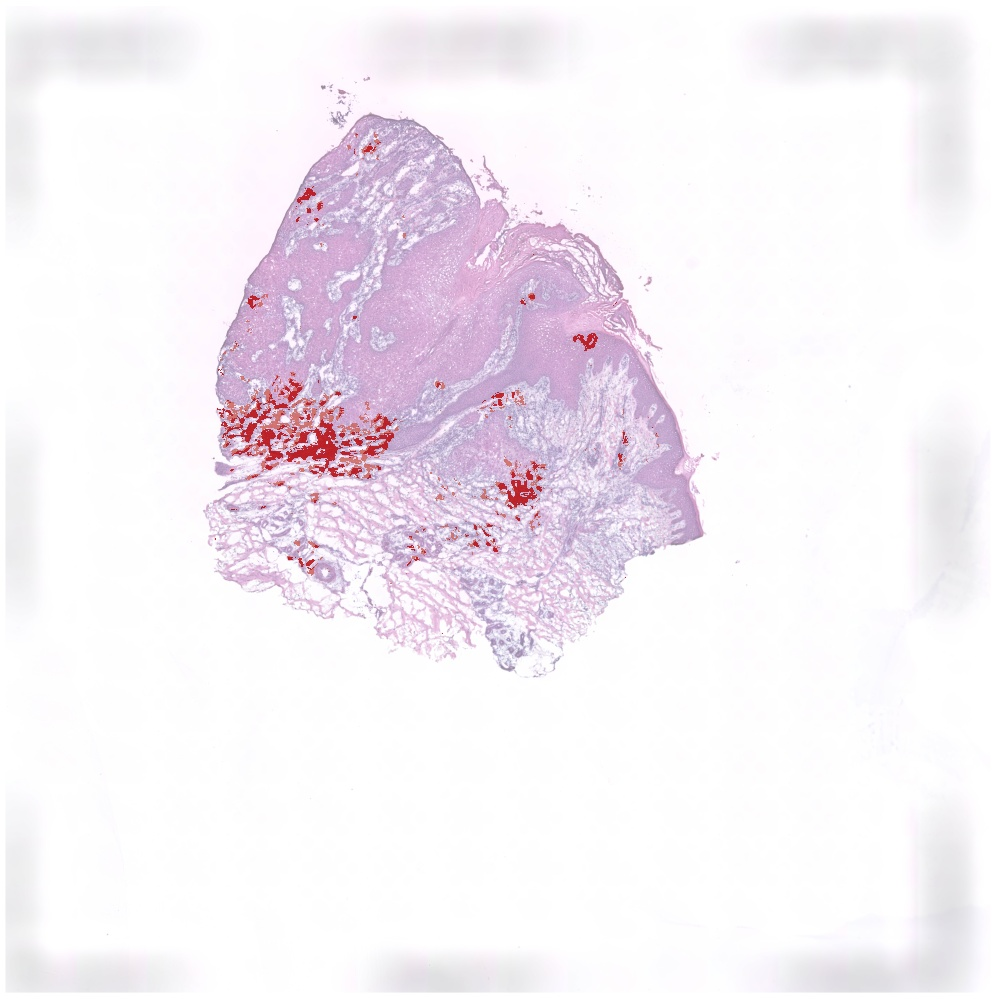

In [12]:
Image(filename='./test.jpg')